# Actor-Critic

This Notebook reimplements PyTorch's actor-critic example for Cartpole for Pong. The code runs into GPU memory error.



In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import gym
import random
import torch
import pickle as pickle
import pympler
import gc

# For advanced computer vision
import cv2

# For memory tracking
from pympler import summary
from pympler import muppy

cpu_dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.4


In [2]:
import gc
gc.collect()

11

## Implement Actor-Critic in PyTorch with GPU Acceleration

We implement the ACTOR-CRITIC-Pong in PyTorch:
 
(1) We update the parameters of both Actor and Critic at batch_size so that we no longer encounter GPU memory errors. It takes 0.9sec to play 800 steps. So 20K batches takes 4 hours  
(3) The algorithm's performance using RmsProp at lr = 1e-3 flattens at 1.0

The code is based on PyTorch's example for Actor-Critic which masters the simple game of Cartpole: 

https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py

The pseudo-code for ACTOR-CRITIC is as followed:

```
# Q Actor-Critic Pseudo-Code
    function QAC
    Initialise s, θ
    Sample a ∼ π_θ # sample an action
    for each step do
        Sample reward r = R_sa ; sample transition s′ = P_sa ;
        # sample next action according to our policy
        Sample action a′ ~ π_θ(s′, a′)
        δ = r + γQ_w(s′, a′) − Q_w(s, a) # get TD error
        θ = θ + α∇_θ log π_θ(s, a)Q_w(s, a) # update actor policy
        w ← w + βδ∅(s, a)
        # update critic
        a ← a′ , s ← s′
```

where  


In [5]:
import argparse
import gym
import time
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
render=False
verbose=False  # To step through the code and understand what is going on
log_interval=10
batch_size = 1200  # Start out with 1200 games steps before actor and critic parameter update


env = gym.make("Pong-v0")

# This is saved as a list and used to update the Actor and Critic's parameters
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

# The function approximators for the Actor and the Critic is a 2-layer NN with 2 heads
# - The NN takes in the state of Pong, which is a resampled 40x40 image
# - there are 512 hidden units in the NN
# - The action_head (Actor) computes softmax output for actions (L and R) 
# - The value_head (Critic) computes an estimate for the value function Q_w(s, a)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 512)
        self.action_head = nn.Linear(512, 2)
        self.value_head = nn.Linear(512, 1)  

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

def process_frame40(frame):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (40, 40))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.reshape(frame, [-1])
    return frame


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """

    state = torch.from_numpy(state).float()
    # Use Policy to generate probability for actions and value function
    probs, state_value = model(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    
    # Store log_prob (score function) and value function into a list to update Actor and Critic 
    # parameters later on
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_batch():
    """ 
    In this implementation, Actor and Critic parameters are updated at the end of a batch of 
    game steps. This is necessary to prevent GPU memory error.
    """

    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []     # This is Q(s,a)

    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in model.rewards[::-1]:
        if r != 0:  # reset the sum, since this was a game boundary (pong specific!)
            R = 0
        R = r + gamma * R
        rewards.insert(0, R)
        
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    # Calculate gradient for Actor and Critic
    for (log_prob, value), r in zip(saved_actions, rewards):
        # Actor's policy gradient is computed here
        reward = r - value.data[0]   
        policy_losses.append(-log_prob * reward)
        
        # Critic's value gradient is computed here
        value_losses.append(F.smooth_l1_loss(value, Variable(torch.Tensor([r]).type(gpu_dtype))))

        
    optimizer.zero_grad()# zero the gradients before running the optimizer
    
    # Sum Actor and Critic gradients for all time steps in the episode
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # The TRICK: backward() on loss instead of policy
    # Actor's and Critic's parameters are updated here.
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]



# Main loop
lr_rates = [1e-3]

for learning_rate in lr_rates:
    
    running_reward = -21
    
    actorCritic=[]
    
    # Call an instance of the Policy and select ADAM as update rule
    model = Policy().cuda()
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.01)  # RMSProp instead of ADAM
    start = time.time()
    
    print ("Learning Rate = ", learning_rate)

    # for i_episode in count(1):  # Infinite loop
    for i_episode in range(30001): # just run 30000 episode 
        state = env.reset()
        reward_sum = 0
        prev_x = None
        done = False
    
        for t in range(batch_size):

            # Downsample 210x160x3 frame into 1600 (40x40) 1D float vector
            cur_x = process_frame40(state)
            state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
            prev_x = cur_x

            # Sample an action from Policy based on state provided by env
            action = select_action(state)
        
            # step env through the sampled action
            state, reward, done, _ = env.step(action)
            reward_sum += reward
        
            if render:
                env.render()
            
            # append reward to policy.reward[]
            # this is needed to calculate policy gradient at the end of the episode  
            model.rewards.append(reward)
        
            # break if episode is done even if it has not reached batch size
            if done:
                break
            
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    
        # Calculate policy gradient and update Policy 
        finish_batch()
        gc.collect()  # clean up some garbage
        torch.cuda.empty_cache()  # Release GPU memory
    
        actorCritic.append([reward_sum, running_reward])

        # print out and show sign of life
        if i_episode % log_interval == 0:
            print('Batch {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                    i_episode, reward_sum, running_reward))
    
        # track memory usage every 2000 episodes
        if i_episode % 2000 == 0:
            # summary.print_(summary.summarize(muppy.get_objects()))  # track memory usage
            file_name = './results/actor-critic/pong_'+'lr='+str('{:.2e}'.format(learning_rate)) \
                        +'ep='+str(i_episode)+'model.pt'
            torch.save(model.state_dict(), file_name)
        
end = time.time()
print ("Time taken:", start-end)     
env.close()

history_file = './results/actor-critic/pong_'+'ep='+str(i_episode+1)+'history.p'
pickle.dump(actorCritic, open(history_file, 'wb'))

Learning Rate =  0.001
Batch 0	Last Reward: -17.00	Running Reward: -20.96
Batch 10	Last Reward: -14.00	Running Reward: -20.63
Batch 20	Last Reward: -17.00	Running Reward: -20.56
Batch 30	Last Reward: -16.00	Running Reward: -20.25
Batch 40	Last Reward: -19.00	Running Reward: -20.00
Batch 50	Last Reward: -18.00	Running Reward: -19.61
Batch 60	Last Reward: -21.00	Running Reward: -19.56
Batch 70	Last Reward: -17.00	Running Reward: -19.37
Batch 80	Last Reward: -16.00	Running Reward: -19.19
Batch 90	Last Reward: -14.00	Running Reward: -18.93
Batch 100	Last Reward: -21.00	Running Reward: -18.51
Batch 110	Last Reward: -19.00	Running Reward: -18.38
Batch 120	Last Reward: -8.00	Running Reward: -18.15
Batch 130	Last Reward: -15.00	Running Reward: -18.02
Batch 140	Last Reward: -18.00	Running Reward: -17.89
Batch 150	Last Reward: -16.00	Running Reward: -17.83
Batch 160	Last Reward: -15.00	Running Reward: -17.66
Batch 170	Last Reward: -19.00	Running Reward: -17.58
Batch 180	Last Reward: -18.00	Runni

Batch 1560	Last Reward: 1.00	Running Reward: -5.45
Batch 1570	Last Reward: -4.00	Running Reward: -5.40
Batch 1580	Last Reward: -3.00	Running Reward: -5.33
Batch 1590	Last Reward: -5.00	Running Reward: -5.26
Batch 1600	Last Reward: -5.00	Running Reward: -5.12
Batch 1610	Last Reward: -1.00	Running Reward: -5.02
Batch 1620	Last Reward: -4.00	Running Reward: -4.82
Batch 1630	Last Reward: -8.00	Running Reward: -4.83
Batch 1640	Last Reward: -6.00	Running Reward: -4.79
Batch 1650	Last Reward: -7.00	Running Reward: -4.82
Batch 1660	Last Reward: -6.00	Running Reward: -4.86
Batch 1670	Last Reward: -3.00	Running Reward: -4.73
Batch 1680	Last Reward: -5.00	Running Reward: -4.56
Batch 1690	Last Reward: 0.00	Running Reward: -4.43
Batch 1700	Last Reward: -1.00	Running Reward: -4.52
Batch 1710	Last Reward: -8.00	Running Reward: -4.47
Batch 1720	Last Reward: -7.00	Running Reward: -4.43
Batch 1730	Last Reward: -6.00	Running Reward: -4.15
Batch 1740	Last Reward: 0.00	Running Reward: -4.09
Batch 1750	Last

Batch 3150	Last Reward: -1.00	Running Reward: -1.33
Batch 3160	Last Reward: 2.00	Running Reward: -1.28
Batch 3170	Last Reward: -4.00	Running Reward: -1.31
Batch 3180	Last Reward: -5.00	Running Reward: -1.23
Batch 3190	Last Reward: 0.00	Running Reward: -1.31
Batch 3200	Last Reward: -5.00	Running Reward: -1.37
Batch 3210	Last Reward: -1.00	Running Reward: -1.35
Batch 3220	Last Reward: -2.00	Running Reward: -1.37
Batch 3230	Last Reward: -4.00	Running Reward: -1.42
Batch 3240	Last Reward: -4.00	Running Reward: -1.47
Batch 3250	Last Reward: 2.00	Running Reward: -1.55
Batch 3260	Last Reward: -3.00	Running Reward: -1.52
Batch 3270	Last Reward: -4.00	Running Reward: -1.45
Batch 3280	Last Reward: -2.00	Running Reward: -1.40
Batch 3290	Last Reward: 0.00	Running Reward: -1.47
Batch 3300	Last Reward: -2.00	Running Reward: -1.51
Batch 3310	Last Reward: 0.00	Running Reward: -1.53
Batch 3320	Last Reward: -6.00	Running Reward: -1.56
Batch 3330	Last Reward: -2.00	Running Reward: -1.57
Batch 3340	Last R

Batch 4740	Last Reward: 2.00	Running Reward: -0.62
Batch 4750	Last Reward: -4.00	Running Reward: -0.63
Batch 4760	Last Reward: 4.00	Running Reward: -0.69
Batch 4770	Last Reward: -2.00	Running Reward: -0.65
Batch 4780	Last Reward: -1.00	Running Reward: -0.67
Batch 4790	Last Reward: 3.00	Running Reward: -0.67
Batch 4800	Last Reward: -3.00	Running Reward: -0.65
Batch 4810	Last Reward: -3.00	Running Reward: -0.58
Batch 4820	Last Reward: 1.00	Running Reward: -0.68
Batch 4830	Last Reward: -3.00	Running Reward: -0.75
Batch 4840	Last Reward: 0.00	Running Reward: -0.67
Batch 4850	Last Reward: -8.00	Running Reward: -0.83
Batch 4860	Last Reward: 3.00	Running Reward: -0.65
Batch 4870	Last Reward: -4.00	Running Reward: -0.68
Batch 4880	Last Reward: 0.00	Running Reward: -0.71
Batch 4890	Last Reward: 2.00	Running Reward: -0.68
Batch 4900	Last Reward: -1.00	Running Reward: -0.51
Batch 4910	Last Reward: -4.00	Running Reward: -0.56
Batch 4920	Last Reward: -2.00	Running Reward: -0.61
Batch 4930	Last Rewa

Batch 6340	Last Reward: -1.00	Running Reward: -0.31
Batch 6350	Last Reward: -1.00	Running Reward: -0.25
Batch 6360	Last Reward: -2.00	Running Reward: -0.33
Batch 6370	Last Reward: -2.00	Running Reward: -0.51
Batch 6380	Last Reward: -2.00	Running Reward: -0.54
Batch 6390	Last Reward: 1.00	Running Reward: -0.50
Batch 6400	Last Reward: -2.00	Running Reward: -0.52
Batch 6410	Last Reward: -4.00	Running Reward: -0.62
Batch 6420	Last Reward: 3.00	Running Reward: -0.60
Batch 6430	Last Reward: -4.00	Running Reward: -0.70
Batch 6440	Last Reward: 1.00	Running Reward: -0.64
Batch 6450	Last Reward: -5.00	Running Reward: -0.62
Batch 6460	Last Reward: -2.00	Running Reward: -0.71
Batch 6470	Last Reward: -4.00	Running Reward: -0.61
Batch 6480	Last Reward: 4.00	Running Reward: -0.58
Batch 6490	Last Reward: 2.00	Running Reward: -0.51
Batch 6500	Last Reward: -2.00	Running Reward: -0.50
Batch 6510	Last Reward: -1.00	Running Reward: -0.58
Batch 6520	Last Reward: 0.00	Running Reward: -0.66
Batch 6530	Last Re

Batch 7930	Last Reward: -1.00	Running Reward: -0.28
Batch 7940	Last Reward: 2.00	Running Reward: -0.23
Batch 7950	Last Reward: 4.00	Running Reward: -0.09
Batch 7960	Last Reward: 1.00	Running Reward: -0.13
Batch 7970	Last Reward: 1.00	Running Reward: -0.01
Batch 7980	Last Reward: -2.00	Running Reward: -0.06
Batch 7990	Last Reward: 1.00	Running Reward: -0.09
Batch 8000	Last Reward: -1.00	Running Reward: -0.09
Batch 8010	Last Reward: 3.00	Running Reward: -0.19
Batch 8020	Last Reward: -3.00	Running Reward: -0.17
Batch 8030	Last Reward: 0.00	Running Reward: -0.09
Batch 8040	Last Reward: 2.00	Running Reward: -0.08
Batch 8050	Last Reward: 2.00	Running Reward: -0.04
Batch 8060	Last Reward: 1.00	Running Reward: -0.04
Batch 8070	Last Reward: 5.00	Running Reward: 0.07
Batch 8080	Last Reward: -1.00	Running Reward: 0.12
Batch 8090	Last Reward: -2.00	Running Reward: 0.02
Batch 8100	Last Reward: 2.00	Running Reward: 0.03
Batch 8110	Last Reward: -1.00	Running Reward: -0.04
Batch 8120	Last Reward: 2.00

Batch 9530	Last Reward: -4.00	Running Reward: 0.26
Batch 9540	Last Reward: 2.00	Running Reward: 0.29
Batch 9550	Last Reward: 2.00	Running Reward: 0.32
Batch 9560	Last Reward: -5.00	Running Reward: 0.22
Batch 9570	Last Reward: -3.00	Running Reward: 0.28
Batch 9580	Last Reward: 2.00	Running Reward: 0.34
Batch 9590	Last Reward: 0.00	Running Reward: 0.28
Batch 9600	Last Reward: 2.00	Running Reward: 0.22
Batch 9610	Last Reward: -3.00	Running Reward: 0.27
Batch 9620	Last Reward: 3.00	Running Reward: 0.18
Batch 9630	Last Reward: -4.00	Running Reward: 0.11
Batch 9640	Last Reward: -2.00	Running Reward: 0.10
Batch 9650	Last Reward: -1.00	Running Reward: 0.05
Batch 9660	Last Reward: 3.00	Running Reward: 0.06
Batch 9670	Last Reward: 0.00	Running Reward: 0.19
Batch 9680	Last Reward: 7.00	Running Reward: 0.30
Batch 9690	Last Reward: -1.00	Running Reward: 0.21
Batch 9700	Last Reward: -1.00	Running Reward: 0.19
Batch 9710	Last Reward: -2.00	Running Reward: 0.13
Batch 9720	Last Reward: 6.00	Running Rew

Batch 11130	Last Reward: -1.00	Running Reward: 0.32
Batch 11140	Last Reward: -3.00	Running Reward: 0.20
Batch 11150	Last Reward: 2.00	Running Reward: 0.14
Batch 11160	Last Reward: 1.00	Running Reward: 0.07
Batch 11170	Last Reward: -2.00	Running Reward: 0.14
Batch 11180	Last Reward: -4.00	Running Reward: 0.25
Batch 11190	Last Reward: -2.00	Running Reward: 0.23
Batch 11200	Last Reward: -2.00	Running Reward: 0.22
Batch 11210	Last Reward: -1.00	Running Reward: 0.24
Batch 11220	Last Reward: 1.00	Running Reward: 0.42
Batch 11230	Last Reward: -1.00	Running Reward: 0.41
Batch 11240	Last Reward: -2.00	Running Reward: 0.41
Batch 11250	Last Reward: 0.00	Running Reward: 0.48
Batch 11260	Last Reward: -1.00	Running Reward: 0.41
Batch 11270	Last Reward: -1.00	Running Reward: 0.29
Batch 11280	Last Reward: -4.00	Running Reward: 0.22
Batch 11290	Last Reward: -1.00	Running Reward: 0.25
Batch 11300	Last Reward: -3.00	Running Reward: 0.31
Batch 11310	Last Reward: 0.00	Running Reward: 0.31
Batch 11320	Last 

Batch 12730	Last Reward: 2.00	Running Reward: 0.68
Batch 12740	Last Reward: 0.00	Running Reward: 0.55
Batch 12750	Last Reward: 3.00	Running Reward: 0.55
Batch 12760	Last Reward: 3.00	Running Reward: 0.65
Batch 12770	Last Reward: -2.00	Running Reward: 0.72
Batch 12780	Last Reward: -3.00	Running Reward: 0.60
Batch 12790	Last Reward: 0.00	Running Reward: 0.72
Batch 12800	Last Reward: 1.00	Running Reward: 0.84
Batch 12810	Last Reward: 4.00	Running Reward: 0.80
Batch 12820	Last Reward: 4.00	Running Reward: 0.83
Batch 12830	Last Reward: 1.00	Running Reward: 0.90
Batch 12840	Last Reward: -3.00	Running Reward: 0.88
Batch 12850	Last Reward: -3.00	Running Reward: 0.78
Batch 12860	Last Reward: -1.00	Running Reward: 0.84
Batch 12870	Last Reward: 2.00	Running Reward: 0.78
Batch 12880	Last Reward: 4.00	Running Reward: 0.78
Batch 12890	Last Reward: -1.00	Running Reward: 0.86
Batch 12900	Last Reward: 1.00	Running Reward: 0.82
Batch 12910	Last Reward: 0.00	Running Reward: 0.73
Batch 12920	Last Reward: 

Batch 14330	Last Reward: -2.00	Running Reward: 0.51
Batch 14340	Last Reward: 0.00	Running Reward: 0.58
Batch 14350	Last Reward: -5.00	Running Reward: 0.70
Batch 14360	Last Reward: -1.00	Running Reward: 0.71
Batch 14370	Last Reward: 2.00	Running Reward: 0.66
Batch 14380	Last Reward: -3.00	Running Reward: 0.53
Batch 14390	Last Reward: 0.00	Running Reward: 0.57
Batch 14400	Last Reward: 3.00	Running Reward: 0.66
Batch 14410	Last Reward: 4.00	Running Reward: 0.66
Batch 14420	Last Reward: 3.00	Running Reward: 0.61
Batch 14430	Last Reward: 2.00	Running Reward: 0.75
Batch 14440	Last Reward: -4.00	Running Reward: 0.70
Batch 14450	Last Reward: -1.00	Running Reward: 0.70
Batch 14460	Last Reward: 1.00	Running Reward: 0.64
Batch 14470	Last Reward: -5.00	Running Reward: 0.56
Batch 14480	Last Reward: 1.00	Running Reward: 0.52
Batch 14490	Last Reward: -2.00	Running Reward: 0.41
Batch 14500	Last Reward: -1.00	Running Reward: 0.31
Batch 14510	Last Reward: 5.00	Running Reward: 0.38
Batch 14520	Last Rewar

Batch 15930	Last Reward: 3.00	Running Reward: 0.62
Batch 15940	Last Reward: 4.00	Running Reward: 0.66
Batch 15950	Last Reward: -2.00	Running Reward: 0.66
Batch 15960	Last Reward: 3.00	Running Reward: 0.60
Batch 15970	Last Reward: 5.00	Running Reward: 0.66
Batch 15980	Last Reward: 1.00	Running Reward: 0.67
Batch 15990	Last Reward: 2.00	Running Reward: 0.62
Batch 16000	Last Reward: 3.00	Running Reward: 0.73
Batch 16010	Last Reward: -3.00	Running Reward: 0.81
Batch 16020	Last Reward: -2.00	Running Reward: 0.69
Batch 16030	Last Reward: -1.00	Running Reward: 0.74
Batch 16040	Last Reward: -5.00	Running Reward: 0.66
Batch 16050	Last Reward: 1.00	Running Reward: 0.63
Batch 16060	Last Reward: 0.00	Running Reward: 0.60
Batch 16070	Last Reward: 1.00	Running Reward: 0.68
Batch 16080	Last Reward: 2.00	Running Reward: 0.66
Batch 16090	Last Reward: 3.00	Running Reward: 0.83
Batch 16100	Last Reward: -1.00	Running Reward: 0.61
Batch 16110	Last Reward: 6.00	Running Reward: 0.81
Batch 16120	Last Reward: 

Batch 17530	Last Reward: 0.00	Running Reward: 0.30
Batch 17540	Last Reward: -4.00	Running Reward: 0.40
Batch 17550	Last Reward: 0.00	Running Reward: 0.28
Batch 17560	Last Reward: 0.00	Running Reward: 0.22
Batch 17570	Last Reward: 2.00	Running Reward: 0.35
Batch 17580	Last Reward: 2.00	Running Reward: 0.30
Batch 17590	Last Reward: -2.00	Running Reward: 0.35
Batch 17600	Last Reward: 2.00	Running Reward: 0.27
Batch 17610	Last Reward: 0.00	Running Reward: 0.14
Batch 17620	Last Reward: -3.00	Running Reward: 0.12
Batch 17630	Last Reward: 6.00	Running Reward: 0.33
Batch 17640	Last Reward: 3.00	Running Reward: 0.30
Batch 17650	Last Reward: -5.00	Running Reward: 0.32
Batch 17660	Last Reward: 7.00	Running Reward: 0.43
Batch 17670	Last Reward: 0.00	Running Reward: 0.44
Batch 17680	Last Reward: 5.00	Running Reward: 0.54
Batch 17690	Last Reward: -2.00	Running Reward: 0.51
Batch 17700	Last Reward: 2.00	Running Reward: 0.60
Batch 17710	Last Reward: 4.00	Running Reward: 0.61
Batch 17720	Last Reward: 2

Batch 19130	Last Reward: 0.00	Running Reward: 0.77
Batch 19140	Last Reward: 1.00	Running Reward: 0.82
Batch 19150	Last Reward: -1.00	Running Reward: 0.91
Batch 19160	Last Reward: -1.00	Running Reward: 0.82
Batch 19170	Last Reward: 2.00	Running Reward: 0.94
Batch 19180	Last Reward: 1.00	Running Reward: 0.87
Batch 19190	Last Reward: 0.00	Running Reward: 0.91
Batch 19200	Last Reward: 2.00	Running Reward: 0.88
Batch 19210	Last Reward: -1.00	Running Reward: 0.80
Batch 19220	Last Reward: -1.00	Running Reward: 0.81
Batch 19230	Last Reward: 0.00	Running Reward: 0.84
Batch 19240	Last Reward: 2.00	Running Reward: 0.88
Batch 19250	Last Reward: 3.00	Running Reward: 0.91
Batch 19260	Last Reward: 0.00	Running Reward: 0.82
Batch 19270	Last Reward: 0.00	Running Reward: 0.82
Batch 19280	Last Reward: 1.00	Running Reward: 0.67
Batch 19290	Last Reward: -1.00	Running Reward: 0.62
Batch 19300	Last Reward: 2.00	Running Reward: 0.71
Batch 19310	Last Reward: 1.00	Running Reward: 0.70
Batch 19320	Last Reward: 2

Batch 20730	Last Reward: 1.00	Running Reward: 0.77
Batch 20740	Last Reward: 0.00	Running Reward: 0.76
Batch 20750	Last Reward: -1.00	Running Reward: 0.80
Batch 20760	Last Reward: 0.00	Running Reward: 0.84
Batch 20770	Last Reward: -1.00	Running Reward: 0.90
Batch 20780	Last Reward: 0.00	Running Reward: 0.88
Batch 20790	Last Reward: 3.00	Running Reward: 0.84
Batch 20800	Last Reward: -1.00	Running Reward: 0.87
Batch 20810	Last Reward: 4.00	Running Reward: 0.92
Batch 20820	Last Reward: -2.00	Running Reward: 0.87
Batch 20830	Last Reward: 4.00	Running Reward: 0.92
Batch 20840	Last Reward: 0.00	Running Reward: 0.85
Batch 20850	Last Reward: -1.00	Running Reward: 0.79
Batch 20860	Last Reward: -2.00	Running Reward: 0.72
Batch 20870	Last Reward: 1.00	Running Reward: 0.60
Batch 20880	Last Reward: 8.00	Running Reward: 0.73
Batch 20890	Last Reward: 3.00	Running Reward: 0.72
Batch 20900	Last Reward: 2.00	Running Reward: 0.64
Batch 20910	Last Reward: 4.00	Running Reward: 0.66
Batch 20920	Last Reward: 

Batch 22330	Last Reward: 3.00	Running Reward: 0.42
Batch 22340	Last Reward: -1.00	Running Reward: 0.42
Batch 22350	Last Reward: 2.00	Running Reward: 0.50
Batch 22360	Last Reward: -1.00	Running Reward: 0.62
Batch 22370	Last Reward: -2.00	Running Reward: 0.63
Batch 22380	Last Reward: 0.00	Running Reward: 0.74
Batch 22390	Last Reward: 2.00	Running Reward: 0.72
Batch 22400	Last Reward: 5.00	Running Reward: 0.64
Batch 22410	Last Reward: 2.00	Running Reward: 0.59
Batch 22420	Last Reward: -1.00	Running Reward: 0.82
Batch 22430	Last Reward: -2.00	Running Reward: 0.84
Batch 22440	Last Reward: 3.00	Running Reward: 0.73
Batch 22450	Last Reward: 0.00	Running Reward: 0.76
Batch 22460	Last Reward: -3.00	Running Reward: 0.61
Batch 22470	Last Reward: 1.00	Running Reward: 0.69
Batch 22480	Last Reward: 0.00	Running Reward: 0.71
Batch 22490	Last Reward: -1.00	Running Reward: 0.70
Batch 22500	Last Reward: 2.00	Running Reward: 0.72
Batch 22510	Last Reward: 4.00	Running Reward: 0.73
Batch 22520	Last Reward:

Batch 23930	Last Reward: 2.00	Running Reward: 0.58
Batch 23940	Last Reward: -4.00	Running Reward: 0.63
Batch 23950	Last Reward: -2.00	Running Reward: 0.58
Batch 23960	Last Reward: 6.00	Running Reward: 0.57
Batch 23970	Last Reward: 1.00	Running Reward: 0.66
Batch 23980	Last Reward: 2.00	Running Reward: 0.71
Batch 23990	Last Reward: 4.00	Running Reward: 0.71
Batch 24000	Last Reward: 3.00	Running Reward: 0.82
Batch 24010	Last Reward: 0.00	Running Reward: 0.80
Batch 24020	Last Reward: 1.00	Running Reward: 0.84
Batch 24030	Last Reward: -2.00	Running Reward: 0.74
Batch 24040	Last Reward: 0.00	Running Reward: 0.79
Batch 24050	Last Reward: 0.00	Running Reward: 0.63
Batch 24060	Last Reward: -2.00	Running Reward: 0.62
Batch 24070	Last Reward: 2.00	Running Reward: 0.68
Batch 24080	Last Reward: 0.00	Running Reward: 0.60
Batch 24090	Last Reward: 0.00	Running Reward: 0.44
Batch 24100	Last Reward: 2.00	Running Reward: 0.33
Batch 24110	Last Reward: 2.00	Running Reward: 0.45
Batch 24120	Last Reward: 3.

Batch 25530	Last Reward: 2.00	Running Reward: 0.40
Batch 25540	Last Reward: 2.00	Running Reward: 0.49
Batch 25550	Last Reward: -4.00	Running Reward: 0.33
Batch 25560	Last Reward: -4.00	Running Reward: 0.31
Batch 25570	Last Reward: 5.00	Running Reward: 0.41
Batch 25580	Last Reward: 3.00	Running Reward: 0.38
Batch 25590	Last Reward: 0.00	Running Reward: 0.41
Batch 25600	Last Reward: -3.00	Running Reward: 0.39
Batch 25610	Last Reward: 2.00	Running Reward: 0.39
Batch 25620	Last Reward: 4.00	Running Reward: 0.37
Batch 25630	Last Reward: 1.00	Running Reward: 0.42
Batch 25640	Last Reward: -5.00	Running Reward: 0.41
Batch 25650	Last Reward: 4.00	Running Reward: 0.52
Batch 25660	Last Reward: 0.00	Running Reward: 0.59
Batch 25670	Last Reward: -3.00	Running Reward: 0.68
Batch 25680	Last Reward: -1.00	Running Reward: 0.67
Batch 25690	Last Reward: 0.00	Running Reward: 0.57
Batch 25700	Last Reward: -1.00	Running Reward: 0.57
Batch 25710	Last Reward: 2.00	Running Reward: 0.55
Batch 25720	Last Reward:

Batch 27130	Last Reward: 3.00	Running Reward: 0.71
Batch 27140	Last Reward: 5.00	Running Reward: 0.72
Batch 27150	Last Reward: -1.00	Running Reward: 0.61
Batch 27160	Last Reward: 2.00	Running Reward: 0.67
Batch 27170	Last Reward: -1.00	Running Reward: 0.65
Batch 27180	Last Reward: -2.00	Running Reward: 0.64
Batch 27190	Last Reward: 1.00	Running Reward: 0.61
Batch 27200	Last Reward: 0.00	Running Reward: 0.59
Batch 27210	Last Reward: 1.00	Running Reward: 0.65
Batch 27220	Last Reward: -4.00	Running Reward: 0.57
Batch 27230	Last Reward: 1.00	Running Reward: 0.61
Batch 27240	Last Reward: 0.00	Running Reward: 0.48
Batch 27250	Last Reward: -1.00	Running Reward: 0.49
Batch 27260	Last Reward: 1.00	Running Reward: 0.45
Batch 27270	Last Reward: 3.00	Running Reward: 0.58
Batch 27280	Last Reward: -4.00	Running Reward: 0.46
Batch 27290	Last Reward: 3.00	Running Reward: 0.67
Batch 27300	Last Reward: -3.00	Running Reward: 0.65
Batch 27310	Last Reward: 6.00	Running Reward: 0.71
Batch 27320	Last Reward:

Batch 28730	Last Reward: 2.00	Running Reward: 0.56
Batch 28740	Last Reward: -3.00	Running Reward: 0.57
Batch 28750	Last Reward: -1.00	Running Reward: 0.56
Batch 28760	Last Reward: 3.00	Running Reward: 0.44
Batch 28770	Last Reward: 1.00	Running Reward: 0.43
Batch 28780	Last Reward: 2.00	Running Reward: 0.45
Batch 28790	Last Reward: 2.00	Running Reward: 0.57
Batch 28800	Last Reward: 2.00	Running Reward: 0.69
Batch 28810	Last Reward: 0.00	Running Reward: 0.63
Batch 28820	Last Reward: 0.00	Running Reward: 0.60
Batch 28830	Last Reward: -5.00	Running Reward: 0.54
Batch 28840	Last Reward: 4.00	Running Reward: 0.70
Batch 28850	Last Reward: -2.00	Running Reward: 0.70
Batch 28860	Last Reward: 2.00	Running Reward: 0.67
Batch 28870	Last Reward: 2.00	Running Reward: 0.57
Batch 28880	Last Reward: -2.00	Running Reward: 0.54
Batch 28890	Last Reward: 0.00	Running Reward: 0.58
Batch 28900	Last Reward: 1.00	Running Reward: 0.59
Batch 28910	Last Reward: 4.00	Running Reward: 0.75
Batch 28920	Last Reward: 4

In [26]:
file_name = './results/actor-critic/pong_'+'ep='+str(i_episode+1)+'history.p'
pickle.dump(actorCritic, open(file_name, 'wb'))

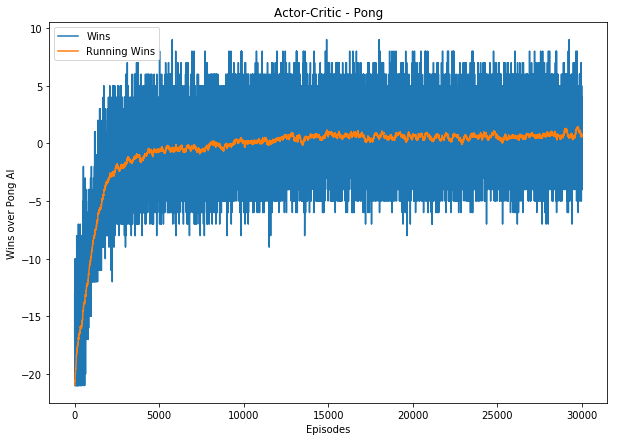

In [6]:
# data = pickle.load(open('./results/actor-critic/pong_ep=20000history.p', 'rb'))
data = actorCritic

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(data)[:,0])+1)), np.array(data)[:,0], label='Wins')
plt.plot(list(range(1,len(np.array(data)[:,1])+1)), np.array(data)[:,1], label='Running Wins')
plt.title('Actor-Critic - Pong')
plt.xlabel('Episodes')
plt.ylabel('Wins over Pong AI')
plt.legend()
plt.show()

In [ ]:
gc.collect()  # clean up some garbage
torch.cuda.empty_cache()  # Release GPU memory

## Load Parameters and Let's Play

The code below loads parameters from saved model into the actor-critic agent and renders 1 episode. The agent and the game will play til one of them reach 21 points.

In [ ]:
import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
verbose=False  # To step through the code and understand what is going on

# The function approximators for the Actor and the Critic is a 2-layer NN with 2 heads
# - The NN takes in the state of Pong, which is a resampled 40x40 image
# - there are 200 hidden units in the NN
# - The action_head (Actor) computes softmax output for actions (L and R) 
# - The value_head (Critic) computes an estimate for the value function Q_w(s, a)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 200)
        self.action_head = nn.Linear(200, 2)
        self.value_head = nn.Linear(200, 1)  

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

def process_frame40(frame):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (40, 40))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.reshape(frame, [-1])
    return frame


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """

    state = torch.from_numpy(state).float()
    # Use Policy to generate probability for actions and value function
    probs, state_value = model(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    
    # Store log_prob (score function) and value function into a list to update Actor and Critic 
    # parameters later on
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    
    return action.data[0]+2  # UP=2, DOWN=3

# Call an instance of the Policy and load it with a parameter file
model = Policy().cuda()
# file_name='./results/actor-critic/pong_ep=18000model.pt'
file_name='./results/actor-critic/pong_ep=6000model.pt'
model.load_state_dict(torch.load(file_name))
model.eval() # Put the model in test mode (the opposite of model.train(), essentially)    

env = gym.make("Pong-v0")
state = env.reset()
prev_x = None # used in computing the difference frame

reward_sum = 0

t = 0

while t < 10000:  # make sure there is no infinite loop
  t += 1
  env.render()
    
  time.sleep(0.01)  # slow it down for us to observe

  # preprocess the observation, set input to network to be difference image
  cur_x = process_frame40(state)
  state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
  prev_x = cur_x

  # Sample an action from Policy based on state provided by env
  action = select_action(state)
        
  # step env through the sampled action
  state, reward, done, _ = env.step(action)
  reward_sum += reward
        
  if done: # an episode finished
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    break

env.close()
print (reward_sum)

## Downsampling

We discover that if we downsample the Pong image to 40x40 using preprop, the pong ball can be sampled out.

We utilize a more sophisticated processing technique from GitHub using cv2

https://github.com/ikostrikov/pytorch-a3c/blob/master/envs.py

(210, 160, 3)
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.25751635  0.25751635  0.25751635 ...,  0.25751635  0.25751635
  0.25751635]


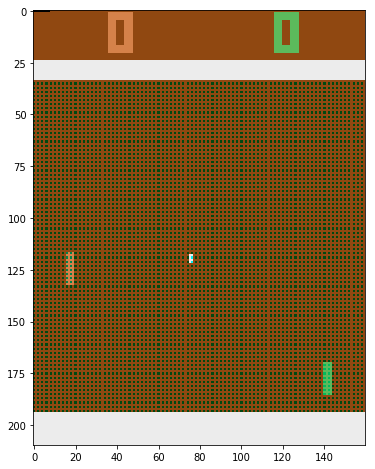

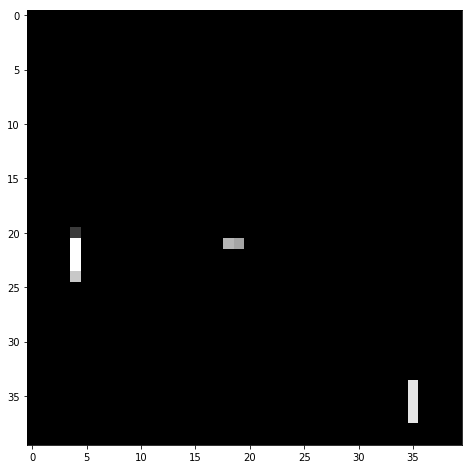

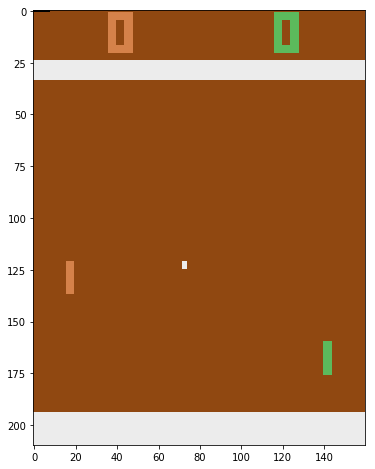

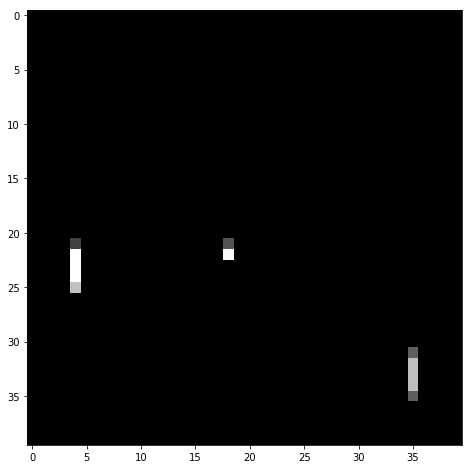

In [39]:
def prepro(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def process_frame42(frame):
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (40, 40))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.reshape(frame, [-1])
    return frame

env = gym.make("Pong-v0")
state = env.reset()
print (state.shape)

for i in range(20):
    action = random.randint(2,3)
    state, reward, done, _ = env.step(action)  # UP=2, DOWN=3

cur_x_1 = prepro(state)
cur_x = process_frame42(state)

print (cur_x_1)
print (cur_x)

plt.figure()
plt.imshow(state) 
plt.show()  # display it

plt.figure()
plt.imshow(cur_x.reshape(40,40)) 
plt.show()  # display it

state, reward, done, _ = env.step(action)  # UP=2, DOWN=3

cur_x = process_frame42(state)

plt.figure()
plt.imshow(state) 
plt.show()  # display it

plt.figure()
plt.imshow(cur_x.reshape(40,40)) 
plt.show()  # display it